# Differential Analysis

Import everything from the imports notebook. This reads in all of the expression data as well as the functions needed to analyse differential expression data.

In [1]:
import NotebookImport
from Imports import *

/cellar/users/agross/anaconda2/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


importing IPython notebook from Imports

In [2]:
import seaborn as sns
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

In [8]:
def pull_out_tn(df, assoication_cutoff=.001):
    """
    Does a reconstruction of the data with on only eigenvectors
    associated with the tumor-normal axis.

    This is done by calculating the signular-value-decomposition
    of the matrix, searching for associations of each eigenvector
    with the tumor-normal change, and finally reconstructing the
    matrix with those not significantly associated zero-ed out.

    Returns a DataFrame of the reconstructed data matrix.

    df:
        DataFrame of measurements.  Should have a multi-index with
        subjects on the first level and tissue type ('01' or '11')
        on the second level.
    """
    df = pd.concat([df.xs('01',1,1), df.xs('11',1,1)],
                    keys=['01','11'], axis=1)
    df.columns = df.columns.swaplevel(0,1)

    svd = frame_svd(df)
    keep = svd[2].apply(ttest_rel).T.p < assoication_cutoff
    S = pd.Series(svd[1]) * 1.*keep
    S = pd.DataFrame(sp.linalg.diagsvd(S, len(S), len(S)), index=S.index,
                     columns=S.index)
    df_new = svd[0].dot(S).dot(svd[2].T)
    return df_new

__matched_meth__ is our matched methylation data.

In [3]:
store = '/data_ssd/TCGA_methylation_2014_04_16.h5'
matched_meth = pd.read_hdf(store, 'matched_tn')
matched_meth = matched_meth.groupby(axis=1, level=[0,1]).first()

In [4]:
matched_meth.T.head(10).T.head()

TCGA-05-5420        TCGA-18-3417        TCGA-18-4721        TCGA-18-5592        TCGA-18-5595      
                             01    11            01    11            01    11            01    11            01    11
Hybridization REF                                                                                                    
cg00000029                 0.38  0.18          0.23  0.18          0.31  0.24          0.17  0.25          0.16  0.16
cg00000165                 0.15  0.11          0.51  0.15          0.40  0.15          0.74  0.14          0.80  0.18
cg00000236                 0.85  0.92          0.91  0.85          0.87  0.88          0.91  0.90          0.90  0.89
cg00000289                 0.71  0.75          0.73  0.77          0.64  0.81          0.67  0.76          0.74  0.77
cg00000292                 0.75  0.71          0.67  0.69          0.77  0.68          0.51  0.68          0.59  0.69

In [5]:
matched_meth.shape[1] / 2

704

Read in matched Gene and miRNA expression data.

In [6]:
matched_rna = matched_tn
matched_mir = pd.read_hdf('/data_ssd/miRNASeq_2015_04_02.h5', 'matched_tn')

### Run a simple screen for DX probes 
* Here we take the matched data and run a basic screen
* fc = 1 means that we have no foldchange buffer for a gene to be considered over or underexpressed in a patient 
* If there are ties or missing data, I omit these from the test.  This can cause underpowered tests which have extreme test statistics but weak p-values.  For this reason I filter all gene/probes/markers with a sample size of less than 300 patients.

In [9]:
matched_rna = pull_out_tn(matched_rna)

In [10]:
dx_rna = binomial_test_screen(matched_rna, fc=1.)
dx_rna = dx_rna[dx_rna.num_dx > 300]

In [11]:
dx_rna.ix[['ADH1A','ADH1B','ADH1C']]

,num_ox,num_dx,frac,p
ADH1A,5,649,0.01,8.15e-184
ADH1B,3,649,0.00,3.90e-188
ADH1C,17,649,0.03,1.29e-162


In [12]:
dx_rna.p.rank().ix[['ADH1A','ADH1B','ADH1C']]

ADH1A     13.5
ADH1B      2.5
ADH1C    341.0
Name: p, dtype: float64

In [13]:
dx_rna.sort('p').head(10)

,num_ox,num_dx,frac,p
IBSP,647,649,1.00,1.81e-190
ADH1B,3,649,0.00,3.90e-188
ADAMTS14,646,649,1.00,3.90e-188
SEMA5B,645,649,0.99,6.31e-186
NXPH4,645,649,0.99,6.31e-186
CDH19,4,649,0.01,6.31e-186
KISS1R,645,649,0.99,6.31e-186
ADH1A,5,649,0.01,8.15e-184
CAMK2N2,644,649,0.99,8.15e-184
RNASE10,644,649,0.99,8.15e-184


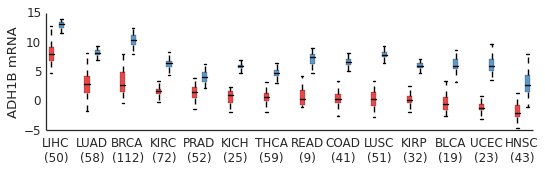

In [14]:
#Do not import
fig, ax = subplots(figsize=(7.75,2.5))
paired_bp_tn_split(matched_rna.ix['ADH1B'], codes, data_type='mRNA',
                   ax=ax)
fig.tight_layout()

In [15]:
matched_mir = pull_out_tn(matched_mir)

In [16]:
dx_mir = binomial_test_screen(matched_mir, fc=1.)
dx_mir = dx_mir[dx_mir.num_dx > 300]

In [17]:
dx_mir.sort('p').head()

,num_ox,num_dx,frac,p
hsa-mir-139,19,642,0.03,1.56e-157
hsa-mir-1247,20,642,0.03,4.88e-156
hsa-mir-383,25,642,0.04,7.08e-149
hsa-mir-3189,616,642,0.96,1.68e-147
hsa-mir-145,28,642,0.04,8.46e-145


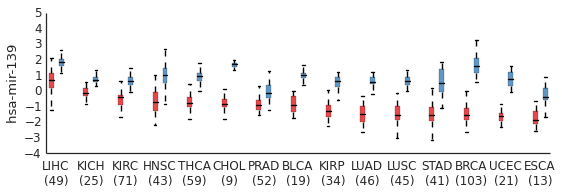

In [18]:
#Do not import
paired_bp_tn_split(matched_mir.ix['hsa-mir-139'], codes, data_type='')

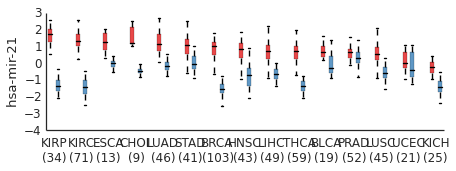

In [19]:
#Do not import
fig, ax = subplots(figsize=(6.5,2.5))
paired_bp_tn_split(matched_mir.ix['hsa-mir-21'], codes, data_type='',
                   ax=ax)
fig.tight_layout()

In [26]:
matched_meth = pull_out_tn(matched_meth)

In [29]:
dx_meth = binomial_test_screen(matched_meth, fc=1.)
dx_meth = dx_meth[dx_meth.num_dx > 300]

In [30]:
dx_meth.sort('p').head()

,num_ox,num_dx,frac,p
Hybridization REF,,,,
cg26708319,700,704,0.99,2.43e-202
cg06829686,700,704,0.99,2.43e-202
cg11823511,700,704,0.99,2.43e-202
cg03255182,700,704,0.99,2.43e-202
cg14979301,699,704,0.99,3.40e-200


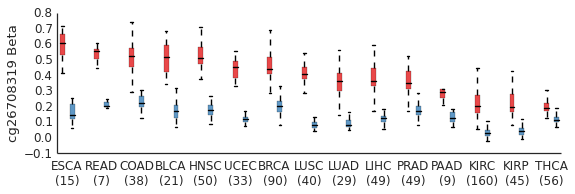

In [31]:
#Do not import
paired_bp_tn_split(matched_meth.ix['cg26708319'], codes, data_type='Beta')

We are going to want to reuse this plot so here I'm wrapping it in a function.

In [32]:
def fig_1e(ax):
    draw_dist(dx_meth.frac, ax=ax, lw=2.5)
    draw_dist(dx_rna.frac, ax=ax, lw=2.5, bins=200)
    draw_dist(dx_mir.frac, ax=ax, lw=2.5, bins=100)


    ax.set_yticks([])
    ax.set_xticks([0,.5,1])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction')
    ax.legend(('Methylation','mRNA','miRNA'), frameon=False)
    prettify_ax(ax)
    return ax

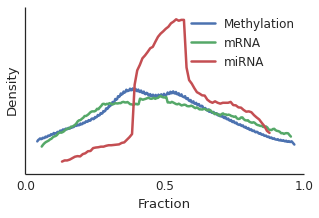

In [33]:
#Do not import
fig, ax = subplots(1,1, figsize=(5,3))
fig_1e(ax);

### Pathway and Gene Annotation Analysis

In [20]:
gs2 = gene_sets.ix[dx_rna.index].fillna(0)

In [21]:
gs2 = gene_sets.ix[dx_rna.index].fillna(0)
rr = screen_feature(dx_rna.frac, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * dx_rna.frac).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

Overexpressed pathways

In [22]:
rr.ix[ti(fp > .5)].join(fp).sort('p').head()

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_CELL_CYCLE,343.11,1.34e-76,1.78e-73,0.75
REACTOME_CELL_CYCLE_MITOTIC,264.02,2.28e-59,1.52e-56,0.75
REACTOME_DNA_REPLICATION,235.90,3.08e-53,1.36e-50,0.80
REACTOME_MITOTIC_M_M_G1_PHASES,209.38,1.87e-47,6.23e-45,0.80
REACTOME_METABOLISM_OF_RNA,174.63,7.23e-40,1.92e-37,0.71


Underexpressed pathways

In [23]:
rr.ix[ti(fp < .5)].join(fp).sort('p').head()

,H,p,q,mean frac
Gene_Set,,,,
NABA_MATRISOME,58.75,1.79e-14,3.60e-13,0.44
KEGG_DRUG_METABOLISM_CYTOCHROME_P450,56.44,5.79e-14,1.13e-12,0.28
NABA_SECRETED_FACTORS,53.15,3.09e-13,5.71e-12,0.40
REACTOME_GPCR_LIGAND_BINDING,49.67,1.82e-12,3.02e-11,0.42
KEGG_FATTY_ACID_METABOLISM,47.69,4.98e-12,7.99e-11,0.23


I am folling up on Fatty Acid Metabolism as opposed to biological oxidations, because it has a larger effect size, although the smaller gene-set size gives it a less extreme p-value.

In [24]:
def fig_1f(ax):
    v = pd.concat([dx_rna.frac, 
                   dx_rna.frac.ix[ti(gs2['REACTOME_CELL_CYCLE']>0)],
                   dx_rna.frac.ix[ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0)]])

    v1 = pd.concat([pd.Series('All Genes', dx_rna.frac.index), 
                    pd.Series('Cell Cycle',
                              ti(gs2['REACTOME_CELL_CYCLE']>0)),
                    pd.Series('Fatty Acid\nMetabolism', 
                              ti(gs2['KEGG_FATTY_ACID_METABOLISM']>0))])
    v1.name = ''
    v.name = 'Fraction Overexpressed'
    violin_plot_pandas(v1, v, ann=None, ax=ax)
    prettify_ax(ax)
    ax.spines['bottom'].set_visible(False)
    ax.axhline(.5, color='grey', lw=2, ls='--')
    return ax

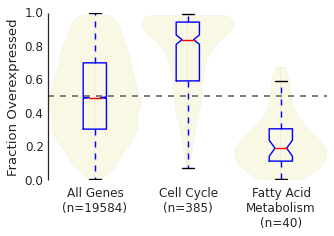

In [25]:
#Do not import
fig, ax = subplots(1,1, figsize=(5,3))
fig_1f(ax)

#### I need to wrap my methylation helper functions into a package

In [34]:
import MethylTools.Probe_Annotations as DX

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

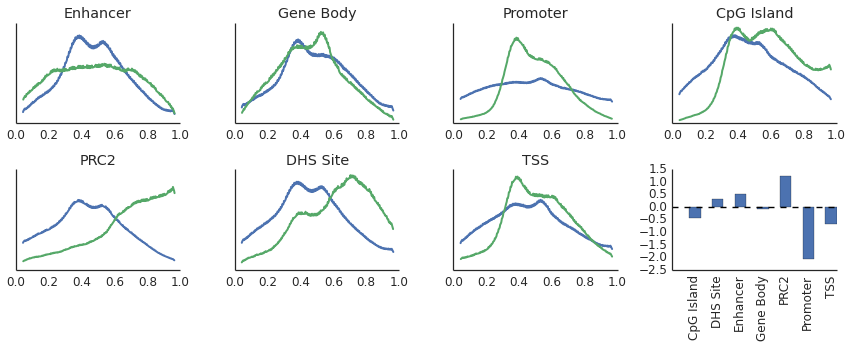

In [35]:
#Do not import
fig, axs = subplots(2,4, figsize=(12,5))
axs = axs.flatten()
for i,p in enumerate(DX.probe_sets.keys()):
    draw_dist(dx_meth.frac, DX.probe_sets[p], ax=axs[i])
    axs[i].legend().set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_title(p)
    prettify_ax(axs[i])
f_odds = pd.DataFrame({f: fisher_exact_test((dx_meth.frac - .5).abs() > .25, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[-1])
prettify_ax(axs[-1])
fig.tight_layout()

In [36]:
def fig_1g(ax):
    lw = 2.5
    draw_dist(dx_meth.frac.ix[ti(DX.probe_sets['Promoter'])], ax=ax, lw=lw)
    draw_dist(dx_meth.frac.ix[ti(DX.probe_sets['CpG Island'])], ax=ax, lw=lw)
    draw_dist(dx_meth.frac.ix[ti(DX.probe_sets['PRC2'])], ax=ax, lw=lw)
    draw_dist(dx_meth.frac, ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_xticks([0,.5,1])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
    prettify_ax(ax)
    return ax

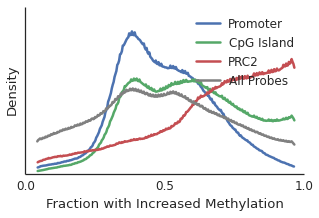

In [37]:
#Do not import
fig, ax = subplots(1,1, figsize=(5,3))
fig_1g(ax);

### Merge Bottom Half of Figure 1

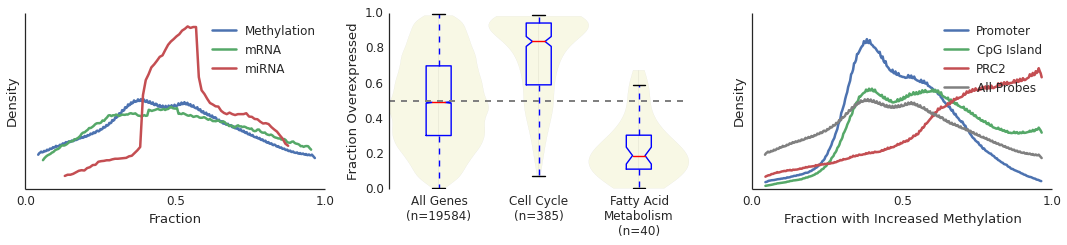

In [38]:
#Do not import
fig, axs = subplots(1,3, figsize=(15,3.5))
fig_1e(axs[0])
fig_1f(axs[1])
fig_1g(axs[2])
fig.tight_layout()
fig.savefig('/cellar/users/agross/figures/fig1_bottom.png', dpi=300)

In [40]:
g = ['PCNA', 'CKS2', 'NUSAP1', 'RRM2', 'ZWINT', 
     'PRC1', 'TFDP1', 'CCNA2', 'CCNB1', 'MELK', 
     'TPX2', 'BIRC5', 'NCAPG2', 'RFWD3', 'TACC3', 
     'KIAA0101', 'MCM2', 'MCM5', 'ASF1B', 'CCNB2', 
     'GTPBP2', 'KIF20A', 'PTTG1', 'AURKA', 'CDC20', 
     'FOXM1', 'GINS2', 'MAD2L1', 'UBE2C', 'GINS1', 
     'MCM6', 'NCAPD2', 'NUP37', 'CKS1B', 'MCM7', 
     'ARID3A', 'AURKB', 'CDCA8', 'SNRPD1', 'TROAP', 
     'C21orf45', 'DDX39', 'ESPL1', 'HMBS', 'LSM6', 
     'MCM4', 'NCAPD3', 'PPIH', 'DTL', 'EPB42', 'HMGN2',
     'MCM3', 'PF4', 'PPBP', 'RFC4', 'TOP2A', 'BUB1B', 
     'CDT1', 'FEN1', 'GATA1', 'GYPB', 'HMGB2', 'KIF22', 
     'KLF1', 'MLF1IP', 'RFC3', 'RHCE', 'TAL1', 'TCF3', 
     'ALAS2', 'CDCA3', 'CENPA', 'CKLF', 'GTSE1', 
     'NFE2', 'OIP5', 'SHCBP1', 'SNF8', 'SNRPB', 'SPTA1', 
     'KEL', 'KIF2C', 'LYL1', 'PSMD9', 'RACGAP1', 'RPIA',
     'TIMELESS', 'TRMT5', 'TYMS', 'VRK1', 'FBXO7', 'H3F3A',
     'NUDT1', 'PLEK', 'POLE2', 'RHAG', 'WHSC1', 'APOBEC3B', 
     'BPGM', 'CHAF1A', 'DNAJC9', 'FBXO5', 'KIF4A', 'KLF15', 
     'MKI67', 'PGD', 'RPA3', 'SFRS2', 'TRIM58', 'ADAMTS13', 
     'CDCA4', 'CDKN3', 'FECH', 'LBR', 'LIG1', 'LMNB1', 'MICB', 
     'NUP210', 'ORC6L', 'RAD51AP1', 'RHD', 'SMC4', 'GYPA', 
     'RPP30', 'TRIM10']
meta_pcna = rna_df.ix[g].median()[:,'01']
meta_pcna.name = 'meta_pcna'
len(meta_pcna)

8556

In [41]:
meta_pcna_all = matched_rna.ix[g].median()
meta_pcna_all.name = 'meta_pcna'
len(meta_pcna_all)

1298

In [42]:
m2 = meta_pcna_all.ix[matched_tn.columns]
print (m2.unstack().T.diff().ix[1] < 0).mean()
(m2.unstack().T.diff().ix[1] < 0).value_counts()

0.973805855162


True     632
False     17
dtype: int64

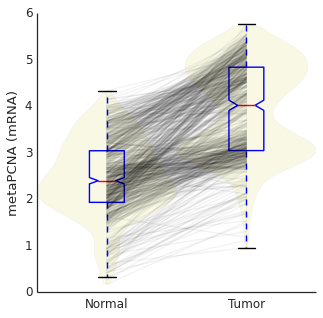

In [43]:
mm = meta_pcna_all.ix[matched_tn.columns]
fig, ax = subplots(figsize=(5,5))
violin_plot_series(mm, ax=ax, order=['11','01'], ann=None)

for i,v in mm.unstack().iterrows():
    ax.plot([0,1],[v['11'], v['01']], color='black', alpha=.05)
ax.set_ylabel('metaPCNA (mRNA)')
ax.set_xlabel('')
ax.set_xticklabels(['Normal','Tumor'])
prettify_ax(ax)
#fig.savefig(FIGDIR + 'tn_tumorness.png', dpi=300)

In [46]:
df_s = pd.read_hdf(STORE, 'robust_within_cancer')
df_s3 = pd.read_hdf(STORE, 'robust_within_cancer_matched')

In [55]:
standardize = lambda s: s.sub(s.median(1), axis=0).div(s.mad(1), axis=0)
def switch_plot(g):
    '''
    Plot to look at the switchiness of an expression signal. 
    '''
    fig = plt.figure(figsize=(10, 6))
    ax1 = plt.subplot2grid((5, 3), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((5, 3), (0, 1), rowspan=3)
    ax3 = plt.subplot2grid((5, 3), (0, 2), rowspan=3)
    ax4 = plt.subplot2grid((5, 3), (3, 0), rowspan=2, colspan=3)
    
    ax=ax1
    series_scatter(meta_pcna_all[:,'01'], matched_rna.ix[g].ix[ti(codes=='KIRC')][:,'01'],
                   color=colors[1], ax=ax, ann=None)
    series_scatter(meta_pcna_all[:,'11'], matched_rna.ix[g].ix[ti(codes=='KIRC')][:,'11'],
                   color=colors[0], ax=ax, ann=None)

    ax=ax2
    v = rna_df.ix[g]
    v2 = pd.concat([standardize(v.ix[ti(codes==c)]) for c in codes.unique()])
    v2 = v2.clip(-5,5)
    series_scatter(meta_pcna_all[:,'01'], matched_rna.ix[g][:,'01'],
                   color=colors[1], ax=ax, s=20, ann=None)
    series_scatter(meta_pcna_all[:,'11'], matched_rna.ix[g][:,'11'],
                   color=colors[0], ax=ax, s=20, ann=None)
    
    ax=ax3
    v = rna_df.ix[g]
    v2 = pd.concat([standardize(v.ix[ti(codes==c)]) for c in codes.unique()])
    v2 = v2.clip(-5,5)
    corr = pearson_pandas(meta_pcna_all[:,'01'], df_s.ix[g].dropna())['rho']
    corr = 'r = {}'.format(round(corr, 2))
    series_scatter(meta_pcna_all[:,'01'], df_s.ix[g].clip(-5,5),
                   color=colors[1], ax=ax, s=20, ann=None)
    ax.annotate(corr, (.65, .05), xycoords='axes fraction', size=16)
    
    paired_bp_tn_split(matched_rna.ix[g], codes, ax=ax4, data_type='exp.')
    
    for ax in [ax1, ax2, ax3]:
        prettify_ax(ax)
        ax.set_xbound(meta_pcna_all.min(), meta_pcna_all.max())
    fig.tight_layout()

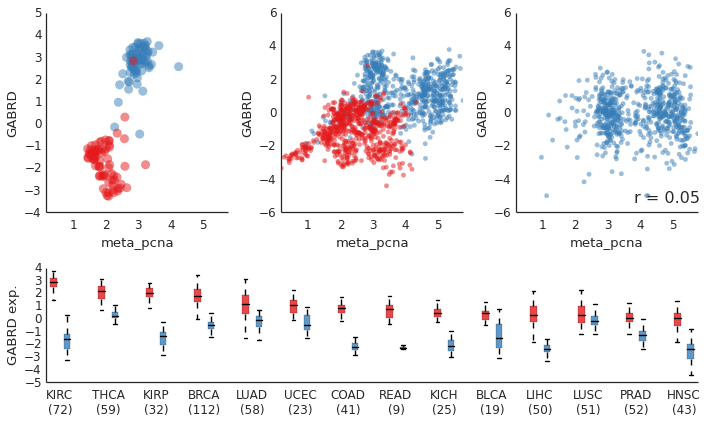

In [56]:
switch_plot('GABRD')

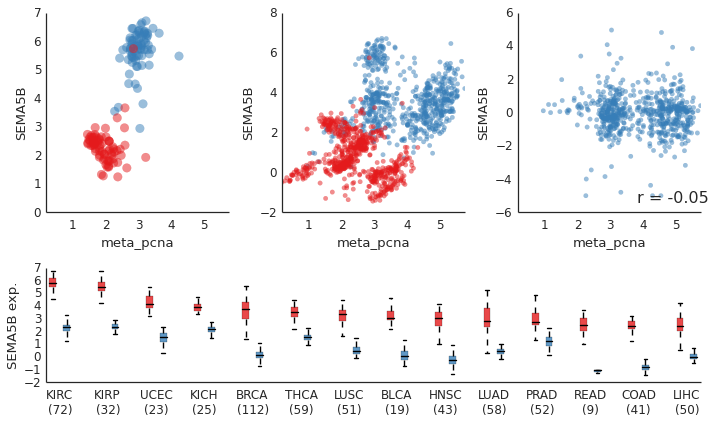

In [58]:
switch_plot('SEMA5B')

In [59]:
dp = -1*meta_pcna_all.unstack()[['01','11']].dropna().T.diff().ix['11']
dp = dp[dp > 0]
#dp = dp - dp.mean()
#dp = dp.groupby(codes).apply(standardize)
dp.name = 'proliferation change'
dx =  matched_tn
dx = dx.xs('01',1,1) - dx.xs('11',1,1)
#dx = (dx - dx.mean())

pcna_corr = dx.T.corrwith(dp)

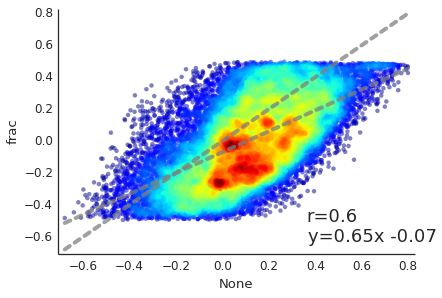

In [62]:
#Do not import
fig, ax = subplots()
plot_regression(pcna_corr.dropna(), dx_rna.frac.dropna() - .5, density=True, rad=.03, s=20,
                rasterized=True, ax=ax)

In [63]:
m = pd.rolling_mean(dx_rna.frac.ix[pcna_corr.order().index].dropna(), 
                    window=500, center=True).dropna()
m2 = pd.rolling_mean(dx_rna.frac.ix[pcna_corr.order().index].dropna(), 
                    window=50, center=True).dropna()
m = m.combine_first(m2)
f_win = (dx_rna.frac - m).dropna()
f_win.name = 'fraction overexpressed\n(detrended)'

In [66]:
f_win.order().tail()

HSD3B7       0.60
LOC221122    0.61
BBC3         0.61
CORO7        0.62
GABRD        0.64
Name: fraction overexpressed\n(detrended), dtype: float64

In [67]:
f_win.order().head()

LRP1B     -0.54
MT1G      -0.54
IPCEF1    -0.52
ZNF804B   -0.52
OCA2      -0.51
Name: fraction overexpressed\n(detrended), dtype: float64

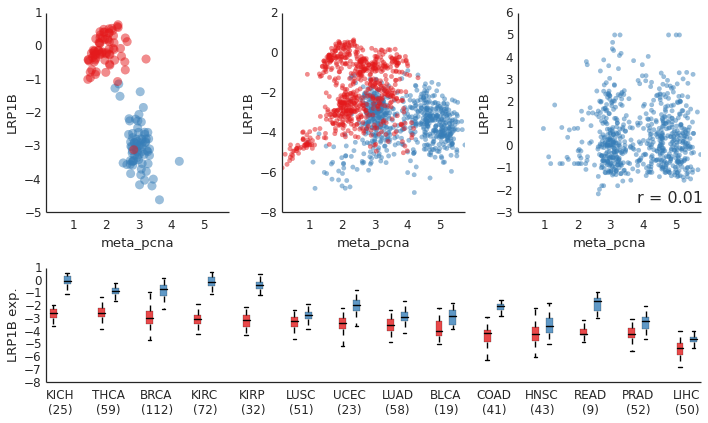

In [68]:
switch_plot('LRP1B')